# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [4]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import MeanShift

from sklearn.ensemble import AdaBoostRegressor # Adaptive Boosting
from sklearn.ensemble import GradientBoostingRegressor # Gradient Tree Boosting

from sklearn.metrics import roc_auc_score, fbeta_score, accuracy_score, precision_score, recall_score

from scipy import stats
from time import time

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

# Data Exploration:

Load the datasets and understand the structure of the data. This includes checking for:

- Missing values
- Duplicates
- Data types (categorical, numerical)
- Distribution of features (to spot any anomalies)

In [53]:
%%time

# Load the datasets
azdias = pd.read_csv('arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')
mailout_train = pd.read_csv('arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_test = pd.read_csv('arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

<timed exec>:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
<timed exec>:3: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
<timed exec>:4: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 13.4 s, sys: 4.67 s, total: 18 s
Wall time: 19.2 s


<timed exec>:5: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.


In [54]:
azdias_original = azdias.copy()
customers_original = customers.copy()
mailout_train_original = mailout_train.copy()
mailout_test_original = mailout_test.copy()

In [55]:
# Check a small sample of the data
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [56]:
# Check data types
azdias.dtypes.value_counts()

float64    267
int64       93
object       6
Name: count, dtype: int64

In [57]:
# Explore the general structure of the data
print("AZDIAS Shape:", azdias.shape)
print("CUSTOMERS Shape:", customers.shape)
print("MAILOUT_TRAIN Shape:", mailout_train.shape)
print("MAILOUT_TEST Shape:", mailout_test.shape)

AZDIAS Shape: (891221, 366)
CUSTOMERS Shape: (191652, 369)
MAILOUT_TRAIN Shape: (42962, 367)
MAILOUT_TEST Shape: (42833, 366)


# Handling Missing Values / Clean Data

- Drop Features: If some columns have too many missing values (e.g., more than 50-60%), it might be best to drop those features entirely.
- Remove Rows: If only a few rows have missing data, we can consider removing them.
- Analyze Columns: Check the values in columns to decide if they provide significant information, especially for categorical ones
- Find Highly Correlative Columns
- Remove Outliers in the Data

In [58]:
# Checking for missing values
azdias_missing = azdias.isnull().sum()
customers_missing = customers.isnull().sum()

azdias_null_percent = azdias_missing / len(azdias) * 100
customers_null_percent = customers_missing / len(customers) * 100

# Summary of missing values
print("AZDIAS Missing Values Summary:\n", azdias_missing[azdias_missing > 0].sort_values(ascending=False))
print("CUSTOMERS Missing Values Summary:\n", customers_missing[customers_missing > 0].sort_values(ascending=False))

AZDIAS Missing Values Summary:
 ALTER_KIND4          890016
ALTER_KIND3          885051
ALTER_KIND2          861722
ALTER_KIND1          810163
EXTSEL992            654153
                      ...  
RT_SCHNAEPPCHEN        4854
RT_KEIN_ANREIZ         4854
RETOURTYP_BK_S         4854
CJT_KATALOGNUTZER      4854
CJT_TYP_2              4854
Length: 273, dtype: int64
CUSTOMERS Missing Values Summary:
 ALTER_KIND4           191416
ALTER_KIND3           190377
ALTER_KIND2           186552
ALTER_KIND1           179886
KK_KUNDENTYP          111937
                       ...  
RETOURTYP_BK_S          3213
CJT_KATALOGNUTZER       3213
CJT_TYP_1               3213
CJT_TYP_6               3213
HH_EINKOMMEN_SCORE      2968
Length: 273, dtype: int64


In [59]:
# Check missing values percentage for the customers dataset
missing_customers = customers.isnull().mean().sort_values(ascending=False)
print(missing_customers)

# Same for the azdias dataset
missing_azdias = azdias.isnull().mean().sort_values(ascending=False)
print(missing_azdias)

ALTER_KIND4                  0.998769
ALTER_KIND3                  0.993347
ALTER_KIND2                  0.973389
ALTER_KIND1                  0.938607
KK_KUNDENTYP                 0.584064
                               ...   
D19_VERSAND_ANZ_24           0.000000
D19_VERSAND_DATUM            0.000000
D19_VERSAND_OFFLINE_DATUM    0.000000
D19_VERSAND_ONLINE_DATUM     0.000000
ALTERSKATEGORIE_GROB         0.000000
Length: 369, dtype: float64
ALTER_KIND4                  0.998648
ALTER_KIND3                  0.993077
ALTER_KIND2                  0.966900
ALTER_KIND1                  0.909048
EXTSEL992                    0.733996
                               ...   
D19_VERSAND_ANZ_24           0.000000
D19_VERSAND_DATUM            0.000000
D19_VERSAND_OFFLINE_DATUM    0.000000
D19_VERSAND_ONLINE_DATUM     0.000000
ALTERSKATEGORIE_GROB         0.000000
Length: 366, dtype: float64


In [60]:
azdias_missing_row = azdias.isnull().sum(axis=1)
azdias_missing_row

0         252
1          15
2           5
3           7
4           5
         ... 
891216     11
891217      6
891218      8
891219      4
891220     16
Length: 891221, dtype: int64

### Preprocessing

In [61]:
azdias_cleaned_rows = azdias[azdias.isnull().sum(axis=1) <= 20].reset_index(drop=True)
print('Shape of original dataset: ',azdias.shape)
print('Shape of new dataset: ',azdias_cleaned_rows.shape)

Shape of original dataset:  (891221, 366)
Shape of new dataset:  (744305, 366)


In [62]:
columns_empty = azdias.isnull().mean()
columns_to_drop = azdias.columns[columns_empty > 0.50]
columns_to_drop

Index(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992',
       'KK_KUNDENTYP'],
      dtype='object')

In [63]:
# Match the dataset columns
customers_cleaned = customers.drop(columns=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'])
print('Shape of original dataset: ',customers.shape)
print('Shape of new dataset: ',customers_cleaned.shape)


Shape of original dataset:  (191652, 369)
Shape of new dataset:  (191652, 366)


In [64]:
azdias_cleaned = azdias.drop(columns_to_drop,axis=1)
customers_cleaned = customers_cleaned.drop(columns_to_drop,axis=1)

print('Shape of original azdias dataset: ',azdias.shape)
print('Shape of cleaned azdias dataset: ',azdias_cleaned.shape)

print('Shape of original customers dataset: ',customers.shape)
print('Shape of cleaned customers dataset: ',customers_cleaned.shape)

Shape of original azdias dataset:  (891221, 366)
Shape of cleaned azdias dataset:  (891221, 360)
Shape of original customers dataset:  (191652, 369)
Shape of cleaned customers dataset:  (191652, 360)


### Find Columns that Have too many Distinct Values

In [65]:
threshold = 40
categorical_columns = azdias_cleaned.select_dtypes(include=['object']).columns

# Dictionary to store the number of unique values for each categorical column
unique_values_dict = {}

# Loop through each categorical column and count the number of unique values
for col in categorical_columns:
    unique_values = azdias_cleaned[col].nunique()
    unique_values_dict[col] = unique_values

# Filter out columns that have too many unique values (greater than the threshold)
too_many_unique_values = {col: unique_values for col, unique_values in unique_values_dict.items() if unique_values > threshold}

# Display the columns that have too many unique values
print(f"Columns with more than {threshold} unique values:")
for col, unique_count in too_many_unique_values.items():
    print(f"{col}: {unique_count} unique values")

Columns with more than 40 unique values:
CAMEO_DEU_2015: 45 unique values
CAMEO_INTL_2015: 43 unique values
EINGEFUEGT_AM: 5162 unique values


In [66]:
azdias_cleaned = azdias_cleaned.drop(['EINGEFUEGT_AM'],axis=1)
customers_cleaned = customers_cleaned.drop(['EINGEFUEGT_AM'],axis=1)

azdias_cleaned = azdias_cleaned.drop(['CAMEO_DEU_2015'],axis=1)
customers_cleaned = customers_cleaned.drop(['CAMEO_DEU_2015'],axis=1)

azdias_cleaned = azdias_cleaned.drop(['CAMEO_INTL_2015'],axis=1)
customers_cleaned = customers_cleaned.drop(['CAMEO_INTL_2015'],axis=1)

print('Shape of original azdias dataset: ',azdias.shape)
print('Shape of cleaned azdias dataset: ',azdias_cleaned.shape)

print('Shape of original customers dataset: ',customers.shape)
print('Shape of cleaned customers dataset: ',customers_cleaned.shape)

Shape of original azdias dataset:  (891221, 366)
Shape of cleaned azdias dataset:  (891221, 357)
Shape of original customers dataset:  (191652, 369)
Shape of cleaned customers dataset:  (191652, 357)


### Find Highly Correlative Columns

In [69]:
import numpy as np
import pandas as pd

# Set a correlation threshold, e.g., 0.9 for high correlation
correlation_threshold = 0.85

# Select numerical columns only
numerical_columns = azdias_cleaned.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix
corr_matrix = numerical_columns.corr()

# Find highly correlated pairs where the absolute correlation is greater than the threshold
high_corr_pairs = np.where(np.abs(corr_matrix) > correlation_threshold)

# Store the highly correlated pairs in a list
high_corr_list = []

# Iterate over the pairs and filter out duplicates (only upper triangle of matrix)
for i in range(len(high_corr_pairs[0])):
    if high_corr_pairs[0][i] != high_corr_pairs[1][i]:  # Exclude diagonal
        col1 = corr_matrix.columns[high_corr_pairs[0][i]]
        col2 = corr_matrix.columns[high_corr_pairs[1][i]]
        high_corr_list.append((col1, col2, corr_matrix.iloc[high_corr_pairs[0][i], high_corr_pairs[1][i]]))

# Convert the list to a DataFrame for easy viewing
high_corr_df = pd.DataFrame(high_corr_list, columns=['Feature 1', 'Feature 2', 'Correlation'])

# Sort by absolute correlation value in descending order
high_corr_df = high_corr_df.sort_values(by='Correlation', ascending=False)

# Display the highly correlated features
print("Highly Correlated Features (Correlation > 0.9):")
print(high_corr_df)

Highly Correlated Features (Correlation > 0.9):
                     Feature 1                   Feature 2  Correlation
29                  PLZ8_ANTG4                 KBA13_ANTG4     0.899595
22                 KBA13_ANTG4                  PLZ8_ANTG4     0.899595
0                    CJT_TYP_1                   CJT_TYP_2     0.897413
1                    CJT_TYP_2                   CJT_TYP_1     0.897413
11             KBA05_KRSHERST1                KBA05_HERST1     0.889293
9                 KBA05_HERST1             KBA05_KRSHERST1     0.889293
2             D19_BANKEN_DATUM     D19_BANKEN_ONLINE_DATUM     0.887769
3      D19_BANKEN_ONLINE_DATUM            D19_BANKEN_DATUM     0.887769
16                  KBA05_SEG2              KBA05_KRSKLEIN     0.886267
12              KBA05_KRSKLEIN                  KBA05_SEG2     0.886267
13               KBA05_KRSOBER                  KBA05_SEG5     0.885538
17                  KBA05_SEG5               KBA05_KRSOBER     0.885538
7            D19

In [70]:
# List of columns to drop based on high correlation
columns_to_drop = [col for col, _, _ in high_corr_list]

# Drop the highly correlated columns from both azdias_cleaned and customers_cleaned datasets
azdias_cleaned = azdias_cleaned.drop(columns=columns_to_drop, axis=1)
customers_cleaned = customers_cleaned.drop(columns=columns_to_drop, axis=1)

# Check the new shapes of the datasets to ensure columns are dropped correctly
print(f"AZDIAS dataset shape after dropping: {azdias_cleaned.shape}")
print(f"CUSTOMERS dataset shape after dropping: {customers_cleaned.shape}")

AZDIAS dataset shape after dropping: (891221, 284)
CUSTOMERS dataset shape after dropping: (191652, 284)


In [71]:
# Identify categorical columns (of type 'object')
categorical_columns = azdias_cleaned.select_dtypes(include=['object']).columns.tolist()

# Optionally, add numeric columns that are known to represent categories (manual selection)
# For example: 'AGER_TYP' or any other known categorical numeric column
categorical_columns += ['AGER_TYP']  # Add any additional numeric category columns

# Print categorical columns
print("Categorical columns identified:", categorical_columns)

Categorical columns identified: ['CAMEO_DEUG_2015', 'D19_LETZTER_KAUF_BRANCHE', 'OST_WEST_KZ', 'AGER_TYP']


In [72]:
# Loop through each column and print its unique values
for col in categorical_columns:
    unique_values = azdias_cleaned[col].unique()  # Get unique values
    print(f"Unique values in {col}:")
    print(unique_values)
    print("\n")  # Add a new line for readability

Unique values in CAMEO_DEUG_2015:
[nan 8.0 4.0 2.0 6.0 1.0 9.0 5.0 7.0 3.0 '4' '3' '7' '2' '8' '9' '6' '5'
 '1' 'X']


Unique values in D19_LETZTER_KAUF_BRANCHE:
[nan 'D19_UNBEKANNT' 'D19_SCHUHE' 'D19_ENERGIE' 'D19_KOSMETIK'
 'D19_VOLLSORTIMENT' 'D19_SONSTIGE' 'D19_BANKEN_GROSS'
 'D19_DROGERIEARTIKEL' 'D19_HANDWERK' 'D19_BUCH_CD' 'D19_VERSICHERUNGEN'
 'D19_VERSAND_REST' 'D19_TELKO_REST' 'D19_BANKEN_DIREKT' 'D19_BANKEN_REST'
 'D19_FREIZEIT' 'D19_LEBENSMITTEL' 'D19_HAUS_DEKO' 'D19_BEKLEIDUNG_REST'
 'D19_SAMMELARTIKEL' 'D19_TELKO_MOBILE' 'D19_REISEN' 'D19_BEKLEIDUNG_GEH'
 'D19_TECHNIK' 'D19_NAHRUNGSERGAENZUNG' 'D19_DIGIT_SERV' 'D19_LOTTO'
 'D19_RATGEBER' 'D19_TIERARTIKEL' 'D19_KINDERARTIKEL' 'D19_BIO_OEKO'
 'D19_WEIN_FEINKOST' 'D19_GARTEN' 'D19_BILDUNG' 'D19_BANKEN_LOKAL']


Unique values in OST_WEST_KZ:
[nan 'W' 'O']


Unique values in AGER_TYP:
[-1  2  3  0  1]




In [74]:
# Handle NaN values for CAMEO_DEUG_2015 (replace with 'X')
azdias_cleaned['CAMEO_DEUG_2015'].fillna('X', inplace=True)
customers_cleaned['CAMEO_DEUG_2015'].fillna('X', inplace=True)

# Handle NaN values for other categorical columns (replace with 'Unknown')
for col in ['D19_LETZTER_KAUF_BRANCHE', 'OST_WEST_KZ', 'AGER_TYP']:
    azdias_cleaned[col].fillna(-1, inplace=True)
    customers_cleaned[col].fillna(-1, inplace=True)

# Verify that NaN values are handled
print("AZDIAS missing values:\n", azdias_cleaned[['CAMEO_DEUG_2015', 'D19_LETZTER_KAUF_BRANCHE', 'OST_WEST_KZ', 'AGER_TYP']].isnull().sum())
print("\nCUSTOMERS missing values:\n", customers_cleaned[['CAMEO_DEUG_2015', 'D19_LETZTER_KAUF_BRANCHE', 'OST_WEST_KZ', 'AGER_TYP']].isnull().sum())

AZDIAS missing values:
 CAMEO_DEUG_2015             0
D19_LETZTER_KAUF_BRANCHE    0
OST_WEST_KZ                 0
AGER_TYP                    0
dtype: int64

CUSTOMERS missing values:
 CAMEO_DEUG_2015             0
D19_LETZTER_KAUF_BRANCHE    0
OST_WEST_KZ                 0
AGER_TYP                    0
dtype: int64


/var/folders/ss/9g03411n5sgb8vs4fvgmqlfw0000gp/T/ipykernel_21560/629934750.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  azdias_cleaned[col].fillna(-1, inplace=True)
/var/folders/ss/9g03411n5sgb8vs4fvgmqlfw0000gp/T/ipykernel_21560/629934750.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beh

### Impute Columns

In [75]:
from sklearn.impute import SimpleImputer
import pandas as pd

# Define the imputer for numerical columns using the 'most_frequent' strategy
imputer = SimpleImputer(strategy='most_frequent')

# Select numerical columns
numerical_columns_azdias = azdias_cleaned.select_dtypes(include=['float64', 'int64']).columns
numerical_columns_customers = customers_cleaned.select_dtypes(include=['float64', 'int64']).columns

# Apply the imputer to numerical columns for both datasets
azdias_cleaned[numerical_columns_azdias] = imputer.fit_transform(azdias_cleaned[numerical_columns_azdias])
customers_cleaned[numerical_columns_customers] = imputer.transform(customers_cleaned[numerical_columns_customers])

# Confirm imputation by checking if any NaNs remain
print("Remaining NaN values in azdias_cleaned:")
print(azdias_cleaned[numerical_columns_azdias].isnull().sum())

print("Remaining NaN values in customers_cleaned:")
print(customers_cleaned[numerical_columns_customers].isnull().sum())

Remaining NaN values in azdias_cleaned:
LNR                     0
AGER_TYP                0
AKT_DAT_KL              0
ALTER_HH                0
ALTERSKATEGORIE_FEIN    0
                       ..
WOHNDAUER_2008          0
WOHNLAGE                0
ZABEOTYP                0
ANREDE_KZ               0
ALTERSKATEGORIE_GROB    0
Length: 281, dtype: int64
Remaining NaN values in customers_cleaned:
LNR                     0
AGER_TYP                0
AKT_DAT_KL              0
ALTER_HH                0
ALTERSKATEGORIE_FEIN    0
                       ..
WOHNDAUER_2008          0
WOHNLAGE                0
ZABEOTYP                0
ANREDE_KZ               0
ALTERSKATEGORIE_GROB    0
Length: 281, dtype: int64


### One Hot Encoding

In [77]:
# Categorical columns identified earlier
categorical_columns = ['CAMEO_DEUG_2015', 'D19_LETZTER_KAUF_BRANCHE', 'OST_WEST_KZ', 'AGER_TYP']

# Apply one-hot encoding to the categorical columns in azdias and customers datasets
azdias_encoded = pd.get_dummies(azdias_cleaned, columns=categorical_columns, drop_first=True)
customers_encoded = pd.get_dummies(customers_cleaned, columns=categorical_columns, drop_first=True)

# Ensure that both datasets have the same columns after encoding
customers_encoded = customers_encoded.reindex(columns=azdias_encoded.columns, fill_value=0)

# Check the new shapes to confirm the encoding was successful
print("Shape of AZDIAS after one-hot encoding:", azdias_encoded.shape)
print("Shape of CUSTOMERS after one-hot encoding:", customers_encoded.shape)

# Optional: Inspect the first few rows to ensure it looks correct
print(azdias_encoded.head())
print(customers_encoded.head())

Shape of AZDIAS after one-hot encoding: (891221, 339)
Shape of CUSTOMERS after one-hot encoding: (191652, 339)
        LNR  AKT_DAT_KL  ALTER_HH  ALTERSKATEGORIE_FEIN  ANZ_HH_TITEL  \
0  910215.0         1.0       0.0                  15.0           0.0   
1  910220.0         9.0       0.0                  21.0           0.0   
2  910225.0         9.0      17.0                  17.0           0.0   
3  910226.0         1.0      13.0                  13.0           0.0   
4  910241.0         1.0      20.0                  14.0           0.0   

   ANZ_KINDER  ANZ_PERSONEN  ANZ_TITEL  ARBEIT  BALLRAUM  ...  \
0         0.0           1.0        0.0     4.0       6.0  ...   
1         0.0           2.0        0.0     3.0       6.0  ...   
2         0.0           1.0        0.0     3.0       2.0  ...   
3         0.0           0.0        0.0     2.0       4.0  ...   
4         0.0           4.0        0.0     4.0       2.0  ...   

   D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN  \
0        

In [78]:
azdias_preprocessed = azdias_encoded.copy()
customers_preprocessed = customers_encoded.copy()

In [80]:
azdias_encoded = azdias_encoded.astype(int)
customers_encoded = customers_encoded.astype(int)

### Removing Outliers

In [81]:
azdias_cleaned = azdias_encoded[(np.abs(stats.zscore(azdias_encoded)) < 6).all(axis=1)]
customers_cleaned = customers_encoded[(np.abs(stats.zscore(customers_encoded)) < 6).all(axis=1)]

print('Shape of original azdias dataset: ',azdias.shape)
print('Shape of cleaned azdias dataset: ',azdias_cleaned.shape)

print('Shape of original customers dataset: ',customers.shape)
print('Shape of cleaned customers dataset: ',customers_cleaned.shape)

Shape of original azdias dataset:  (891221, 366)
Shape of cleaned azdias dataset:  (608862, 339)
Shape of original customers dataset:  (191652, 369)
Shape of cleaned customers dataset:  (119788, 339)


In [82]:
# Backup
azdias_preprocessed = azdias_cleaned
customers_preprocessed = customers_cleaned

### Data Normalization

We need to normalize the numerical features so that they all have similar ranges. This is especially important for models like KMeans that are sensitive to scale.

In [83]:
from sklearn.preprocessing import StandardScaler

# Apply StandardScaler to numerical columns
scaler = StandardScaler()

# Normalize both datasets: This will standardize all numerical features to have a mean of 0 and a standard deviation of 1.
azdias_normalized = pd.DataFrame(scaler.fit_transform(azdias_cleaned), columns=azdias_cleaned.columns)
customers_normalized = pd.DataFrame(scaler.transform(customers_cleaned), columns=customers_cleaned.columns)

azdias_normalized

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,...,D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN,D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT,D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST,D19_LETZTER_KAUF_BRANCHE_Unknown,OST_WEST_KZ_Unknown,OST_WEST_KZ_W,AGER_TYP_0.0,AGER_TYP_1.0,AGER_TYP_2.0,AGER_TYP_3.0
0,1.055721,-0.941729,-1.099602,0.216556,-0.13804,-0.256371,-0.498224,0.0,0.701040,0.752848,...,-0.274015,-0.222969,0.0,1.244636,2.437102,-1.432849,0.0,-0.29386,-0.333919,-0.168641
1,1.055760,1.197129,1.028332,0.686944,-0.13804,-0.256371,-0.498224,0.0,-0.346949,-1.122310,...,-0.274015,-0.222969,0.0,-0.803448,-0.410323,0.697910,0.0,-0.29386,-0.333919,-0.168641
2,1.055764,-0.941729,0.527642,-0.253831,-0.13804,-0.256371,-1.504569,0.0,-1.394939,-0.184731,...,-0.274015,-0.222969,0.0,-0.803448,-0.410323,0.697910,0.0,-0.29386,2.994734,-0.168641
3,1.055849,1.197129,-1.099602,0.216556,-0.13804,-0.256371,-0.498224,0.0,0.701040,0.752848,...,-0.274015,-0.222969,0.0,-0.803448,-0.410323,0.697910,0.0,-0.29386,-0.333919,-0.168641
4,1.055900,-0.941729,0.652814,-0.018637,-0.13804,-0.256371,-0.498224,0.0,-1.394939,-1.122310,...,-0.274015,-0.222969,0.0,-0.803448,-0.410323,0.697910,0.0,-0.29386,-0.333919,-0.168641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608857,0.728304,1.197129,0.777987,0.216556,-0.13804,-0.256371,-0.498224,0.0,-0.346949,-1.591099,...,-0.274015,-0.222969,0.0,1.244636,-0.410323,0.697910,0.0,-0.29386,-0.333919,-0.168641
608858,0.728342,1.197129,1.028332,0.686944,-0.13804,-0.256371,-0.498224,0.0,-0.346949,0.752848,...,-0.274015,-0.222969,0.0,-0.803448,-0.410323,0.697910,0.0,-0.29386,-0.333919,-0.168641
608859,0.728443,1.197129,0.903160,0.451750,-0.13804,-0.256371,-0.498224,0.0,0.701040,1.221637,...,-0.274015,-0.222969,0.0,-0.803448,-0.410323,0.697910,0.0,-0.29386,-0.333919,-0.168641
608860,0.728463,1.197129,-1.099602,1.392525,-0.13804,2.262624,-0.498224,0.0,0.701040,-1.122310,...,-0.274015,-0.222969,0.0,-0.803448,-0.410323,0.697910,0.0,-0.29386,-0.333919,-0.168641


In [84]:
azdias_normalized.to_csv("azdias_preprocessed.csv")
customers_normalized.to_csv("customers_preprocessed.csv")

In [85]:
azdias_normalized.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,...,D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN,D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT,D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST,D19_LETZTER_KAUF_BRANCHE_Unknown,OST_WEST_KZ_Unknown,OST_WEST_KZ_W,AGER_TYP_0.0,AGER_TYP_1.0,AGER_TYP_2.0,AGER_TYP_3.0
0,1.055721,-0.941729,-1.099602,0.216556,-0.13804,-0.256371,-0.498224,0.0,0.701040,0.752848,...,-0.274015,-0.222969,0.0,1.244636,2.437102,-1.432849,0.0,-0.29386,-0.333919,-0.168641
1,1.055760,1.197129,1.028332,0.686944,-0.13804,-0.256371,-0.498224,0.0,-0.346949,-1.122310,...,-0.274015,-0.222969,0.0,-0.803448,-0.410323,0.697910,0.0,-0.29386,-0.333919,-0.168641
2,1.055764,-0.941729,0.527642,-0.253831,-0.13804,-0.256371,-1.504569,0.0,-1.394939,-0.184731,...,-0.274015,-0.222969,0.0,-0.803448,-0.410323,0.697910,0.0,-0.29386,2.994734,-0.168641
3,1.055849,1.197129,-1.099602,0.216556,-0.13804,-0.256371,-0.498224,0.0,0.701040,0.752848,...,-0.274015,-0.222969,0.0,-0.803448,-0.410323,0.697910,0.0,-0.29386,-0.333919,-0.168641
4,1.055900,-0.941729,0.652814,-0.018637,-0.13804,-0.256371,-0.498224,0.0,-1.394939,-1.122310,...,-0.274015,-0.222969,0.0,-0.803448,-0.410323,0.697910,0.0,-0.29386,-0.333919,-0.168641


In [86]:
customers_normalized.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,...,D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN,D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT,D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST,D19_LETZTER_KAUF_BRANCHE_Unknown,OST_WEST_KZ_Unknown,OST_WEST_KZ_W,AGER_TYP_0.0,AGER_TYP_1.0,AGER_TYP_2.0,AGER_TYP_3.0
0,-2.434677,-0.941729,0.152124,-0.959413,-0.13804,-0.256371,0.508121,0.0,-2.442929,-0.653521,...,-0.274015,-0.222969,0.0,-0.803448,-0.410323,0.69791,0.0,-0.293860,2.994734,-0.168641
1,-1.914235,-0.941729,0.152124,-1.194606,-0.13804,-0.256371,0.508121,0.0,-0.346949,0.284058,...,-0.274015,-0.222969,0.0,-0.803448,-0.410323,0.69791,0.0,3.402986,-0.333919,-0.168641
2,-2.075994,-0.941729,1.403850,-0.253831,-0.13804,-0.256371,1.514466,0.0,-0.346949,-1.122310,...,-0.274015,-0.222969,0.0,-0.803448,-0.410323,0.69791,0.0,3.402986,-0.333919,-0.168641
3,-2.075785,-0.941729,1.529023,-0.018637,-0.13804,-0.256371,1.514466,0.0,-2.442929,0.752848,...,3.649440,-0.222969,0.0,-0.803448,-0.410323,0.69791,0.0,-0.293860,-0.333919,-0.168641
4,-2.044582,0.127700,1.028332,-0.489025,-0.13804,-0.256371,3.527155,0.0,-0.346949,-1.122310,...,-0.274015,-0.222969,0.0,-0.803448,-0.410323,0.69791,0.0,-0.293860,2.994734,-0.168641


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

# Dimensionality Reduction

Since we have a large number of features, using dimensionality reduction techniques will help simplify the data while retaining important information. This is especially useful for clustering, which benefits from a lower-dimensional representation of the data.

**Principal Component Analysis (PCA):** PCA is a great technique to reduce the dimensionality of the data while retaining as much variance as possible.

In [88]:
from sklearn.decomposition import PCA

# Apply PCA to reduce dimensionality
pca = PCA(n_components=0.98)  # Retain 98% of variance
azdias_pca = pca.fit_transform(azdias_normalized)
customers_pca = pca.transform(customers_normalized)

# Check how much variance is explained by the selected components
explained_variance = pca.explained_variance_ratio_.sum()
print(f"Explained variance by PCA components: {explained_variance:.2%}")

Explained variance by PCA components: 98.02%


In [89]:
print('Shape of original azdias dataset: ',azdias.shape)
print('Shape of reduced azdias dataset: ',azdias_pca.shape)

print('Shape of original customers dataset: ',customers.shape)
print('Shape of reduced customers dataset: ',customers_pca.shape)

Shape of original azdias dataset:  (891221, 366)
Shape of reduced azdias dataset:  (608862, 251)
Shape of original customers dataset:  (191652, 369)
Shape of reduced customers dataset:  (119788, 251)


# Clustering

### KMeans Clustering:

We can start with KMeans and determine the optimal number of clusters using the elbow method. This will help identify the ideal number of clusters based on the data’s characteristics.

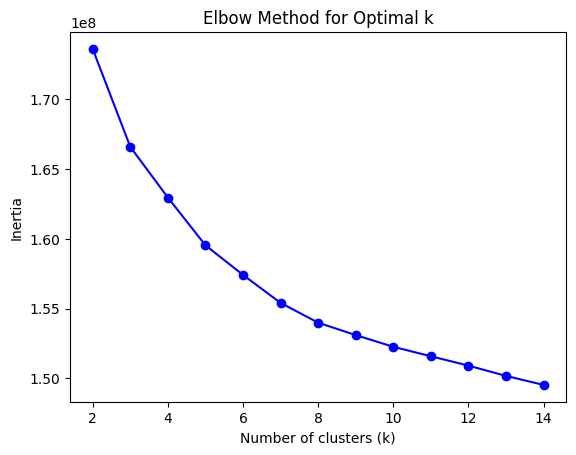

In [92]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Try different values of k to determine the optimal number of clusters
inertia = []
k_values = range(2, 15)  # Try k from 2 to 10

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(azdias_pca)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(k_values, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [93]:
optimal_k = 8
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
azdias_clusters = kmeans.fit_predict(azdias_pca)
customers_clusters = kmeans.predict(customers_pca)

# Add the cluster labels to the original data
azdias_cleaned['Cluster'] = azdias_clusters
customers_cleaned['Cluster'] = customers_clusters

/var/folders/ss/9g03411n5sgb8vs4fvgmqlfw0000gp/T/ipykernel_21560/4287950655.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  azdias_cleaned['Cluster'] = azdias_clusters
/var/folders/ss/9g03411n5sgb8vs4fvgmqlfw0000gp/T/ipykernel_21560/4287950655.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customers_cleaned['Cluster'] = customers_clusters


### Cluster Analysis

In [94]:
# Analyze only the numeric columns by excluding non-numeric types
azdias_cluster_summary = azdias_cleaned.select_dtypes(include=['float64', 'int64']).groupby(azdias_cleaned['Cluster']).mean()
customers_cluster_summary = customers_cleaned.select_dtypes(include=['float64', 'int64']).groupby(customers_cleaned['Cluster']).mean()

# Display the summaries
print(azdias_cluster_summary)
print(customers_cluster_summary)

                   LNR  AKT_DAT_KL   ALTER_HH  ALTERSKATEGORIE_FEIN  \
Cluster                                                               
0        651721.243715    1.199369   0.147258             14.958796   
1        696480.175242    5.366815   8.844650             13.759743   
2        290449.411122    4.951912   9.279447             13.522196   
3        700135.982901    6.560097  11.163686             16.566510   
4        695326.440405    3.529507   8.327722             10.952974   
5        694169.310395    4.895687   7.154411             11.568449   
6        642978.460471    6.529922  10.568423             16.132869   
7        661329.101349    2.659790  15.639626             15.299913   

         ANZ_HH_TITEL  ANZ_KINDER  ANZ_PERSONEN  ANZ_TITEL    ARBEIT  \
Cluster                                                                
0            0.000065    0.001466      1.006599        0.0  3.996753   
1            0.056115    0.070822      1.383820        0.0  3.146778   
2

In [95]:
# Cluster distribution in general population (AZDIAS)
general_population_cluster_counts = pd.Series(azdias_clusters).value_counts(normalize=True)
print("General Population Cluster Distribution:")
print(general_population_cluster_counts)

# Cluster distribution in customers
customer_cluster_counts = pd.Series(customers_clusters).value_counts(normalize=True)
print("\nCustomer Cluster Distribution:")
print(customer_cluster_counts)

General Population Cluster Distribution:
3    0.151090
4    0.142635
5    0.141988
6    0.134204
0    0.125441
7    0.105643
2    0.103964
1    0.095035
Name: proportion, dtype: float64

Customer Cluster Distribution:
0    0.389889
4    0.253573
7    0.153989
1    0.094968
5    0.077019
2    0.017281
3    0.008390
6    0.004892
Name: proportion, dtype: float64


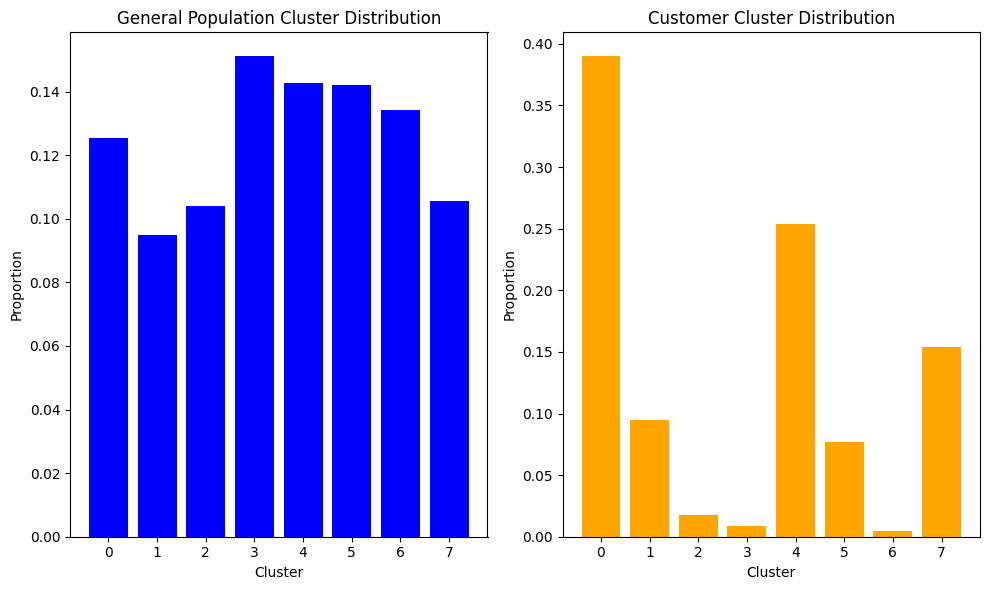

In [96]:
import matplotlib.pyplot as plt

# Plot side by side comparison of cluster distribution
plt.figure(figsize=(10, 6))

# General Population
plt.subplot(1, 2, 1)
plt.bar(general_population_cluster_counts.index, general_population_cluster_counts.values, color='blue')
plt.title('General Population Cluster Distribution')
plt.xlabel('Cluster')
plt.ylabel('Proportion')

# Customers
plt.subplot(1, 2, 2)
plt.bar(customer_cluster_counts.index, customer_cluster_counts.values, color='orange')
plt.title('Customer Cluster Distribution')
plt.xlabel('Cluster')
plt.ylabel('Proportion')

plt.tight_layout()
plt.show()

In [97]:
# Create a DataFrame to store the cluster information
population_cluster_df = pd.DataFrame({'Cluster': azdias_cleaned['Cluster']})
customer_cluster_df = pd.DataFrame({'Cluster': customers_cleaned['Cluster']})

# Count the number of people in each cluster for both population and customers
population_cluster_counts = population_cluster_df['Cluster'].value_counts().sort_index()
customer_cluster_counts = customer_cluster_df['Cluster'].value_counts().sort_index()

# Create a summary DataFrame
cluster_summary = pd.DataFrame({
    'Population': population_cluster_counts,
    'Customer': customer_cluster_counts
})

# Fill missing values with 0 for clusters with no customers
cluster_summary.fillna(0, inplace=True)

# Calculate the proportion of Population/Customer
cluster_summary['% Population/Customer'] = cluster_summary['Population'] / cluster_summary['Customer']

# Print the summary
print(cluster_summary)

         Population  Customer  % Population/Customer
Cluster                                             
0             76376     46704               1.635320
1             57863     11376               5.086410
2             63300      2070              30.579710
3             91993      1005              91.535323
4             86845     30375               2.859095
5             86451      9226               9.370366
6             81712       586             139.440273
7             64322     18446               3.487043


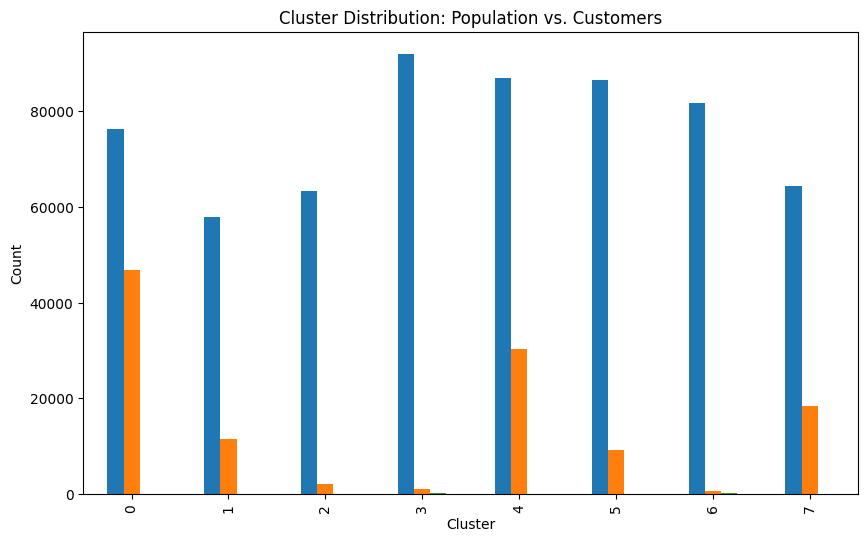

In [99]:
import matplotlib.pyplot as plt

# Plot side by side comparison of Population and Customers per cluster
cluster_summary.plot(kind='bar', figsize=(10, 6))
plt.title('Cluster Distribution: Population vs. Customers')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend().set_visible(False)
plt.show()

### Observations from the Plot:

- Cluster 0 and Cluster 7: These clusters show a higher number of customers compared to other clusters. Both clusters seem to have a considerable amount of the customer data.
- Cluster 1 and Cluster 4: These clusters also show some overrepresentation but to a lesser extent compared to clusters 0 and 7.
- Cluster 6 and Cluster 3: These clusters are underrepresented in the customer data compared to the general population.

In [101]:
# Step 1: Group the data by clusters (for both general population and customers)
population_cluster_summary = azdias_cleaned.groupby('Cluster').mean()
customers_cluster_summary = customers_cleaned.groupby('Cluster').mean()

# Step 2: Focus on overrepresented clusters (e.g., 0, 4, 7)
overrepresented_clusters = [0, 4, 7]

# Step 3: Extract summary statistics for the overrepresented clusters
print("General Population Summary for Overrepresented Clusters:")
print(population_cluster_summary.loc[overrepresented_clusters])

print("\nCustomer Data Summary for Overrepresented Clusters:")
print(customers_cluster_summary.loc[overrepresented_clusters])

General Population Summary for Overrepresented Clusters:
                   LNR  AKT_DAT_KL   ALTER_HH  ALTERSKATEGORIE_FEIN  \
Cluster                                                               
0        651721.243715    1.199369   0.147258             14.958796   
4        695326.440405    3.529507   8.327722             10.952974   
7        661329.101349    2.659790  15.639626             15.299913   

         ANZ_HH_TITEL  ANZ_KINDER  ANZ_PERSONEN  ANZ_TITEL    ARBEIT  \
Cluster                                                                
0            0.000065    0.001466      1.006599        0.0  3.996753   
4            0.003869    0.040175      1.546560        0.0  2.563418   
7            0.005737    0.417633      2.746292        0.0  2.875595   

         BALLRAUM  ...  D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN  \
Cluster            ...                                                
0        5.990507  ...                                     0.000642   
4        5.03

In [102]:
# We can also visualize key features to compare:
for cluster in overrepresented_clusters:
    print(f"\nKey features for Cluster {cluster} in the general population vs. customer data:")
    print(f"Population Data for Cluster {cluster}:\n", population_cluster_summary.loc[cluster])
    print(f"Customer Data for Cluster {cluster}:\n", customers_cluster_summary.loc[cluster])


Key features for Cluster 0 in the general population vs. customer data:
Population Data for Cluster 0:
 LNR                     651721.243715
AKT_DAT_KL                   1.199369
ALTER_HH                     0.147258
ALTERSKATEGORIE_FEIN        14.958796
ANZ_HH_TITEL                 0.000065
                            ...      
OST_WEST_KZ_W                0.004321
AGER_TYP_0.0                 0.000000
AGER_TYP_1.0                 0.000144
AGER_TYP_2.0                 0.000838
AGER_TYP_3.0                 0.000707
Name: 0, Length: 339, dtype: float64
Customer Data for Cluster 0:
 LNR                     95464.588279
AKT_DAT_KL                  1.004218
ALTER_HH                    0.013939
ALTERSKATEGORIE_FEIN       14.993084
ANZ_HH_TITEL                0.000000
                            ...     
OST_WEST_KZ_W               0.000107
AGER_TYP_0.0                0.000000
AGER_TYP_1.0                0.000043
AGER_TYP_2.0                0.000278
AGER_TYP_3.0                0.000150
Nam

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

# Data Preparation for Supervised Learning

In [281]:
mailout_train = pd.read_csv('arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_test = pd.read_csv('arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/var/folders/ss/9g03411n5sgb8vs4fvgmqlfw0000gp/T/ipykernel_21560/2289860824.py:1: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  mailout_train = pd.read_csv('arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
/var/folders/ss/9g03411n5sgb8vs4fvgmqlfw0000gp/T/ipykernel_21560/2289860824.py:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  mailout_test = pd.read_csv('arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')


In [282]:
mailout_train_original = mailout_train.copy()
mailout_test_original = mailout_test.copy()

In [283]:
X = mailout_train.drop('RESPONSE',axis=1)
y = mailout_train['RESPONSE']

### Do the preprocessing steps for mailout data as well

In [284]:
columns_empty = X.isnull().mean()
columns_to_drop = X.columns[columns_empty > 0.50]
columns_to_drop

Index(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4',
       'KK_KUNDENTYP'],
      dtype='object')

In [285]:
mailout_train_cleaned = X.drop(columns_to_drop,axis=1)
mailout_test_cleaned = mailout_test.drop(columns_to_drop,axis=1)

print('Shape of original train dataset: ',mailout_train_original.shape)
print('Shape of cleaned train dataset: ',mailout_train_cleaned.shape)

print('Shape of original test dataset: ',mailout_train_original.shape)
print('Shape of cleaned test dataset: ',mailout_train_cleaned.shape)

Shape of original train dataset:  (42962, 367)
Shape of cleaned train dataset:  (42962, 361)
Shape of original test dataset:  (42962, 367)
Shape of cleaned test dataset:  (42962, 361)


In [286]:
mailout_train_cleaned = mailout_train_cleaned.drop(['EINGEFUEGT_AM'],axis=1)
mailout_train_cleaned = mailout_train_cleaned.drop(['CAMEO_DEU_2015'],axis=1)
mailout_train_cleaned = mailout_train_cleaned.drop(['CAMEO_INTL_2015'],axis=1)

mailout_test_cleaned = mailout_test_cleaned.drop(['EINGEFUEGT_AM'],axis=1)
mailout_test_cleaned = mailout_test_cleaned.drop(['CAMEO_DEU_2015'],axis=1)
mailout_test_cleaned = mailout_test_cleaned.drop(['CAMEO_INTL_2015'],axis=1)

print('Shape of original train dataset: ',mailout_train_original.shape)
print('Shape of cleaned train dataset: ',mailout_train_cleaned.shape)

print('Shape of original test dataset: ',mailout_train_original.shape)
print('Shape of cleaned test dataset: ',mailout_train_cleaned.shape)

Shape of original train dataset:  (42962, 367)
Shape of cleaned train dataset:  (42962, 358)
Shape of original test dataset:  (42962, 367)
Shape of cleaned test dataset:  (42962, 358)


In [287]:
import numpy as np
import pandas as pd

# Set a correlation threshold, e.g., 0.9 for high correlation
correlation_threshold = 0.85

# Select numerical columns only
numerical_columns = mailout_train_cleaned.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix
corr_matrix = numerical_columns.corr()

# Find highly correlated pairs where the absolute correlation is greater than the threshold
high_corr_pairs = np.where(np.abs(corr_matrix) > correlation_threshold)

# Store the highly correlated pairs in a list
high_corr_list = []

# Iterate over the pairs and filter out duplicates (only upper triangle of matrix)
for i in range(len(high_corr_pairs[0])):
    if high_corr_pairs[0][i] != high_corr_pairs[1][i]:  # Exclude diagonal
        col1 = corr_matrix.columns[high_corr_pairs[0][i]]
        col2 = corr_matrix.columns[high_corr_pairs[1][i]]
        high_corr_list.append((col1, col2, corr_matrix.iloc[high_corr_pairs[0][i], high_corr_pairs[1][i]]))

# Convert the list to a DataFrame for easy viewing
high_corr_df = pd.DataFrame(high_corr_list, columns=['Feature 1', 'Feature 2', 'Correlation'])

# Sort by absolute correlation value in descending order
high_corr_df = high_corr_df.sort_values(by='Correlation', ascending=False)

# Display the highly correlated features
print("Highly Correlated Features (Correlation > 0.9):")
print(high_corr_df)

Highly Correlated Features (Correlation > 0.9):
                     Feature 1            Feature 2  Correlation
58           KBA13_HERST_SONST   KBA13_FAB_SONSTIGE     1.000000
52          KBA13_FAB_SONSTIGE    KBA13_HERST_SONST     1.000000
73         LP_LEBENSPHASE_FEIN  LP_LEBENSPHASE_GROB     0.993245
76         LP_LEBENSPHASE_GROB  LP_LEBENSPHASE_FEIN     0.993245
1   ANZ_STATISTISCHE_HAUSHALTE  ANZ_HAUSHALTE_AKTIV     0.990089
..                         ...                  ...          ...
29            FINANZ_VORSORGER        FINANZ_SPARER    -0.864547
62               KBA13_SITZE_4        KBA13_SITZE_5    -0.874225
63               KBA13_SITZE_5        KBA13_SITZE_4    -0.874225
79                 ORTSGR_KLS9          GEMEINDETYP    -0.931836
30                 GEMEINDETYP          ORTSGR_KLS9    -0.931836

[90 rows x 3 columns]


In [288]:
# List of columns to drop based on high correlation
columns_to_drop = [col for col, _, _ in high_corr_list]

# Drop the highly correlated columns from both azdias_cleaned and customers_cleaned datasets
mailout_train_cleaned = mailout_train_cleaned.drop(columns=columns_to_drop, axis=1)
mailout_test_cleaned = mailout_test_cleaned.drop(columns=columns_to_drop, axis=1)

# Check the new shapes of the datasets to ensure columns are dropped correctly
print('Shape of original train dataset: ',mailout_train_original.shape)
print('Shape of cleaned train dataset: ',mailout_train_cleaned.shape)

print('Shape of original test dataset: ',mailout_train_original.shape)
print('Shape of cleaned test dataset: ',mailout_train_cleaned.shape)

Shape of original train dataset:  (42962, 367)
Shape of cleaned train dataset:  (42962, 289)
Shape of original test dataset:  (42962, 367)
Shape of cleaned test dataset:  (42962, 289)


In [289]:
# Handle NaN values for CAMEO_DEUG_2015 (replace with 'X')
mailout_train_cleaned['CAMEO_DEUG_2015'].fillna('X', inplace=True)
mailout_test_cleaned['CAMEO_DEUG_2015'].fillna('X', inplace=True)

# Handle NaN values for other categorical columns (replace with 'Unknown')
for col in ['D19_LETZTER_KAUF_BRANCHE', 'OST_WEST_KZ', 'AGER_TYP']:
    mailout_train_cleaned[col].fillna(-1, inplace=True)
    mailout_test_cleaned[col].fillna(-1, inplace=True)

/var/folders/ss/9g03411n5sgb8vs4fvgmqlfw0000gp/T/ipykernel_21560/1996023160.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  mailout_train_cleaned['CAMEO_DEUG_2015'].fillna('X', inplace=True)
/var/folders/ss/9g03411n5sgb8vs4fvgmqlfw0000gp/T/ipykernel_21560/1996023160.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are s

### Impute Columns

In [290]:
from sklearn.impute import SimpleImputer
import pandas as pd

# Define the imputer for numerical columns using the 'most_frequent' strategy
imputer = SimpleImputer(strategy='most_frequent')

# Select numerical columns
numerical_columns_mailout = mailout_train_cleaned.select_dtypes(include=['float64', 'int64']).columns

# Apply the imputer to numerical columns for both datasets
mailout_train_cleaned[numerical_columns_mailout] = imputer.fit_transform(mailout_train_cleaned[numerical_columns_mailout])
mailout_test_cleaned[numerical_columns_mailout] = imputer.fit_transform(mailout_test_cleaned[numerical_columns_mailout])

# Confirm imputation by checking if any NaNs remain
print("Remaining NaN values in azdias_cleaned:")
print(mailout_train_cleaned[numerical_columns_mailout].isnull().sum())

Remaining NaN values in azdias_cleaned:
LNR                     0
AGER_TYP                0
AKT_DAT_KL              0
ALTER_HH                0
ALTERSKATEGORIE_FEIN    0
                       ..
WOHNDAUER_2008          0
WOHNLAGE                0
ZABEOTYP                0
ANREDE_KZ               0
ALTERSKATEGORIE_GROB    0
Length: 286, dtype: int64


In [291]:
print('Shape of original train dataset: ',mailout_train_original.shape)
print('Shape of cleaned train dataset: ',mailout_train_cleaned.shape)

print('Shape of original test dataset: ',mailout_train_original.shape)
print('Shape of cleaned test dataset: ',mailout_train_cleaned.shape)

Shape of original train dataset:  (42962, 367)
Shape of cleaned train dataset:  (42962, 289)
Shape of original test dataset:  (42962, 367)
Shape of cleaned test dataset:  (42962, 289)


### One Hot Encoding

In [292]:
# Categorical columns identified earlier
categorical_columns = ['CAMEO_DEUG_2015', 'D19_LETZTER_KAUF_BRANCHE', 'OST_WEST_KZ', 'AGER_TYP']

mailout_train_encoded = pd.get_dummies(mailout_train_cleaned, columns=categorical_columns, drop_first=True)
mailout_test_encoded = pd.get_dummies(mailout_test_cleaned, columns=categorical_columns, drop_first=True)

# Check the new shapes to confirm the encoding was successful
print('Shape of original dataset: ',mailout_train_original.shape)
print('Shape of cleaned dataset: ',mailout_train_cleaned.shape)

print(mailout_train_encoded.head())

# Ensure both datasets have the same columns after encoding
mailout_test_encoded = mailout_test_encoded.reindex(columns=mailout_train_encoded.columns, fill_value=0)

Shape of original dataset:  (42962, 367)
Shape of cleaned dataset:  (42962, 289)
      LNR  AKT_DAT_KL  ALTER_HH  ALTERSKATEGORIE_FEIN  ANZ_HH_TITEL  \
0  1763.0         1.0       8.0                   8.0           0.0   
1  1771.0         4.0      13.0                  13.0           0.0   
2  1776.0         1.0       9.0                   7.0           0.0   
3  1460.0         1.0       6.0                   6.0           0.0   
4  1783.0         1.0       9.0                   9.0           0.0   

   ANZ_KINDER  ANZ_PERSONEN  ANZ_TITEL  ARBEIT  BALLRAUM  ...  \
0         0.0           1.0        0.0     3.0       5.0  ...   
1         0.0           2.0        0.0     2.0       5.0  ...   
2         0.0           0.0        0.0     4.0       1.0  ...   
3         0.0           2.0        0.0     4.0       2.0  ...   
4         0.0           1.0        0.0     3.0       4.0  ...   

   D19_LETZTER_KAUF_BRANCHE_D19_VERSAND_REST  \
0                                      False   
1    

### Normalization

In [293]:
from sklearn.preprocessing import StandardScaler

# Apply StandardScaler to numerical columns
scaler = StandardScaler()

# Normalize both datasets: This will standardize all numerical features to have a mean of 0 and a standard deviation of 1.
mailout_train_normalized = pd.DataFrame(scaler.fit_transform(mailout_train_encoded), columns=mailout_train_encoded.columns)
mailout_test_normalized = pd.DataFrame(scaler.fit_transform(mailout_test_encoded), columns=mailout_test_encoded.columns)

mailout_train_normalized

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,...,D19_LETZTER_KAUF_BRANCHE_D19_VERSAND_REST,D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN,D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT,D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST,OST_WEST_KZ_O,OST_WEST_KZ_W,AGER_TYP_0.0,AGER_TYP_1.0,AGER_TYP_2.0,AGER_TYP_3.0
0,-1.656309,-0.274048,-0.091614,-0.428455,-0.116979,-0.204857,-0.656284,-0.083831,-0.220509,0.203551,...,-0.138797,-0.257011,-0.23723,-0.085392,-0.494196,0.778419,-0.148503,-0.523058,1.563723,-0.241794
1,-1.655987,1.594293,0.650673,0.837103,-0.116979,-0.204857,0.113910,-0.083831,-1.214166,0.203551,...,-0.138797,-0.257011,-0.23723,-0.085392,-0.494196,0.778419,-0.148503,1.911834,-0.639500,-0.241794
2,-1.655785,-0.274048,0.056844,-0.681567,-0.116979,-0.204857,-1.426478,-0.083831,0.773148,-1.704266,...,-0.138797,-0.257011,-0.23723,-0.085392,2.023489,-1.284655,-0.148503,1.911834,-0.639500,-0.241794
3,-1.668538,-0.274048,-0.388528,-0.934679,-0.116979,-0.204857,0.113910,-0.083831,0.773148,-1.227312,...,-0.138797,-0.257011,-0.23723,-0.085392,-0.494196,0.778419,-0.148503,-0.523058,1.563723,-0.241794
4,-1.655502,-0.274048,0.056844,-0.175344,-0.116979,-0.204857,-0.656284,-0.083831,-0.220509,-0.273403,...,-0.138797,-0.257011,-0.23723,-0.085392,-0.494196,0.778419,-0.148503,-0.523058,1.563723,-0.241794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42957,0.949828,-0.274048,-1.279272,0.077768,-0.116979,-0.204857,0.113910,-0.083831,-2.207823,-1.227312,...,-0.138797,-0.257011,-0.23723,-0.085392,-0.494196,0.778419,-0.148503,-0.523058,1.563723,-0.241794
42958,1.001930,-0.274048,-1.279272,1.090215,-0.116979,-0.204857,0.113910,-0.083831,0.773148,0.680505,...,-0.138797,-0.257011,-0.23723,-0.085392,2.023489,-1.284655,-0.148503,-0.523058,-0.639500,-0.241794
42959,1.027921,-0.274048,1.096045,0.077768,-0.116979,-0.204857,0.884104,-0.083831,-2.207823,0.680505,...,-0.138797,-0.257011,-0.23723,-0.085392,-0.494196,0.778419,-0.148503,1.911834,-0.639500,-0.241794
42960,1.040351,-0.274048,1.392960,0.837103,-0.116979,-0.204857,0.884104,-0.083831,-1.214166,0.680505,...,-0.138797,-0.257011,-0.23723,-0.085392,-0.494196,0.778419,-0.148503,-0.523058,1.563723,-0.241794


In [294]:
df_mailout_train = mailout_train_normalized
df_mailout_train.shape

(42962, 344)

In [295]:
y.shape

(42962,)

In [296]:
df_mailout_train.head(5)

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,...,D19_LETZTER_KAUF_BRANCHE_D19_VERSAND_REST,D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN,D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT,D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST,OST_WEST_KZ_O,OST_WEST_KZ_W,AGER_TYP_0.0,AGER_TYP_1.0,AGER_TYP_2.0,AGER_TYP_3.0
0,-1.656309,-0.274048,-0.091614,-0.428455,-0.116979,-0.204857,-0.656284,-0.083831,-0.220509,0.203551,...,-0.138797,-0.257011,-0.23723,-0.085392,-0.494196,0.778419,-0.148503,-0.523058,1.563723,-0.241794
1,-1.655987,1.594293,0.650673,0.837103,-0.116979,-0.204857,0.113910,-0.083831,-1.214166,0.203551,...,-0.138797,-0.257011,-0.23723,-0.085392,-0.494196,0.778419,-0.148503,1.911834,-0.639500,-0.241794
2,-1.655785,-0.274048,0.056844,-0.681567,-0.116979,-0.204857,-1.426478,-0.083831,0.773148,-1.704266,...,-0.138797,-0.257011,-0.23723,-0.085392,2.023489,-1.284655,-0.148503,1.911834,-0.639500,-0.241794
3,-1.668538,-0.274048,-0.388528,-0.934679,-0.116979,-0.204857,0.113910,-0.083831,0.773148,-1.227312,...,-0.138797,-0.257011,-0.23723,-0.085392,-0.494196,0.778419,-0.148503,-0.523058,1.563723,-0.241794
4,-1.655502,-0.274048,0.056844,-0.175344,-0.116979,-0.204857,-0.656284,-0.083831,-0.220509,-0.273403,...,-0.138797,-0.257011,-0.23723,-0.085392,-0.494196,0.778419,-0.148503,-0.523058,1.563723,-0.241794


### Creating Data Splits for Training Validation and Test

In [266]:
print(y.value_counts())

RESPONSE
0    42430
1      532
Name: count, dtype: int64


Data is highly imbalanced, in order to achieve results, we will try randomized under-sampling

In [267]:
X_train = df_mailout_train
y_train = y

In [268]:
from imblearn.under_sampling import RandomUnderSampler

# Sampling strategy to reduce the majority class, but not to the same level as the minority class
undersample = RandomUnderSampler(sampling_strategy=0.05, random_state=42)  # Keeps 50% of majority class

# Apply undersampling
X_train_resampled, y_train_resampled = undersample.fit_resample(X_train, y_train)

# Check the new class distribution
print("Class distribution after undersampling:")
print(y_train_resampled.value_counts())

Class distribution after undersampling:
RESPONSE
0    10640
1      532
Name: count, dtype: int64


In [269]:
X_train, X_val, y_train, y_val = train_test_split(X_train_resampled, y_train_resampled, stratify=y_train_resampled, test_size=0.2)

In [270]:
print(y_train.value_counts())

RESPONSE
0    8511
1     426
Name: count, dtype: int64


### Model 1: XGBoost Regressor

In [271]:
from xgboost.sklearn import XGBRegressor # Extreme Gradient Boosting
import xgboost as xgb

xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(X_train,y_train)

/Users/busraoguzoglu/Desktop/Udacity Capstone Project/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:21:42] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10, n_jobs=None,
             num_parallel_tree=None, ...)

In [272]:
preds = xg_reg.predict(X_val)
preds

array([0.02468823, 0.03737967, 0.04036001, ..., 0.04533944, 0.06013211,
       0.0268136 ], dtype=float32)

In [275]:
print("ROC-AUC Score: {:.4f}".format(roc_auc_score(y_val, preds)))

ROC-AUC Score: 0.7143


### Model 2: Logistic Regression

In [299]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report

# Initialize the Logistic Regression model
log_reg = LogisticRegression(class_weight='balanced', random_state=42)

# Train the model on the resampled training data
log_reg.fit(X_train_resampled, y_train_resampled)

# Predict on validation data
y_val_preds = log_reg.predict(X_val)
y_val_probs = log_reg.predict_proba(X_val)[:, 1]  # Probabilities for ROC-AUC

# Calculate ROC-AUC Score
roc_auc = roc_auc_score(y_val, y_val_probs)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Print classification report
print(classification_report(y_val, y_val_preds))

ROC-AUC Score: 0.8270
              precision    recall  f1-score   support

           0       0.98      0.74      0.84      2129
           1       0.12      0.74      0.21       106

    accuracy                           0.74      2235
   macro avg       0.55      0.74      0.53      2235
weighted avg       0.94      0.74      0.81      2235



/Users/busraoguzoglu/Desktop/Udacity Capstone Project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Part 3: Kaggle Competition

We cannot submit anymore, still created the submission file.

In [297]:
missing = list(np.setdiff1d(mailout_train.columns, mailout_test.columns))
missing

['RESPONSE']

"mailout_test_normalized" is preprocessed test file.

In [300]:
prediction_for_kaggle = log_reg.predict(mailout_test_normalized)

In [301]:
df_kaggle = pd.DataFrame(index=mailout_test['LNR'].astype('int32'), data=prediction_for_kaggle)
df_kaggle.rename(columns={0: "RESPONSE"}, inplace=True)

In [303]:
df_kaggle.to_csv('submission.csv')
df_kaggle.head(10)

,RESPONSE
LNR,
1754,0
1770,1
1465,0
1470,0
1478,1
1782,0
1485,0
1519,0
1835,1
